In [2]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import h5py
import types
import librosa.feature
import librosa.filters
import hmmlearn.hmm
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics
import functools
import itertools
import multiprocessing
import dask_jobqueue
import dask.distributed
import zipfile

In [3]:
import os

os.getcwd()

'C:\\Users\\SAIL'

In [4]:
data=pd.read_csv('stapler-ds.csv')
cols=['id', 'TimeMS', 'Avg_Velocity', 'PWM_Output', 'SG_NoFilter', 'Setpoint', 'StrainGage', 'avg_current', 'current_filter', 'ticks', 'True_Endstop_Time_ms', 'Articulation', 'Tissue', 'Tissue_Thickness_inch', 'Firing_Type']
data=data[cols].rename({'True_Endstop_Time_ms':'Anomaly_At_Time_ms'},axis=1)
annomally =pd.read_csv('4D.csv')
annomally=annomally[cols].rename({'True_Endstop_Time_ms':'Anomaly_At_Time_ms'},axis=1)
normal =pd.read_csv('0D.csv')
normal=normal[cols].rename({'True_Endstop_Time_ms':'Anomaly_At_Time_ms'},axis=1)

In [5]:
measures=['Avg_Velocity','StrainGage','avg_current','PWM_Output']

In [6]:
normal_feature=normal[measures]
normal_lable=normal['Anomaly_At_Time_ms']
annomally_feature=annomally[measures]
annomally_lable=annomally['Anomaly_At_Time_ms']

In [7]:
print('Annomally feature: ', annomally_feature.shape)
print('Normal data: ',normal_feature.shape)

Annomally feature:  (45183, 4)
Normal data:  (1006275, 4)


In [8]:
def plot_measure(df):
  e=np.unique(df['Anomaly_At_Time_ms'])[0]
  df=df[df.TimeMS > 400]
  #plt.plot('TimeMS','StrainGage',data=df)
  #plt.plot('TimeMS','Avg_Velocity',data=df)
  plt.figure(figsize=(16,12))
  for i in range(1,5):
    measure=measures[i-1]
    plt.subplot(2,2,i)
    plt.title(measure.title() + ' from a surgical instrument')
    # naming the x axis
    plt.xlabel('Time in Milliseconds')
    # naming the y axis
    plt.ylabel(measure.title())
    plt.plot('TimeMS',measure,data=df)
    #plt.plot('TimeMS','avg_current',data=df)
    plt.legend(loc="upper left")
    plt.axvline(e, color='r')
  plt.show()

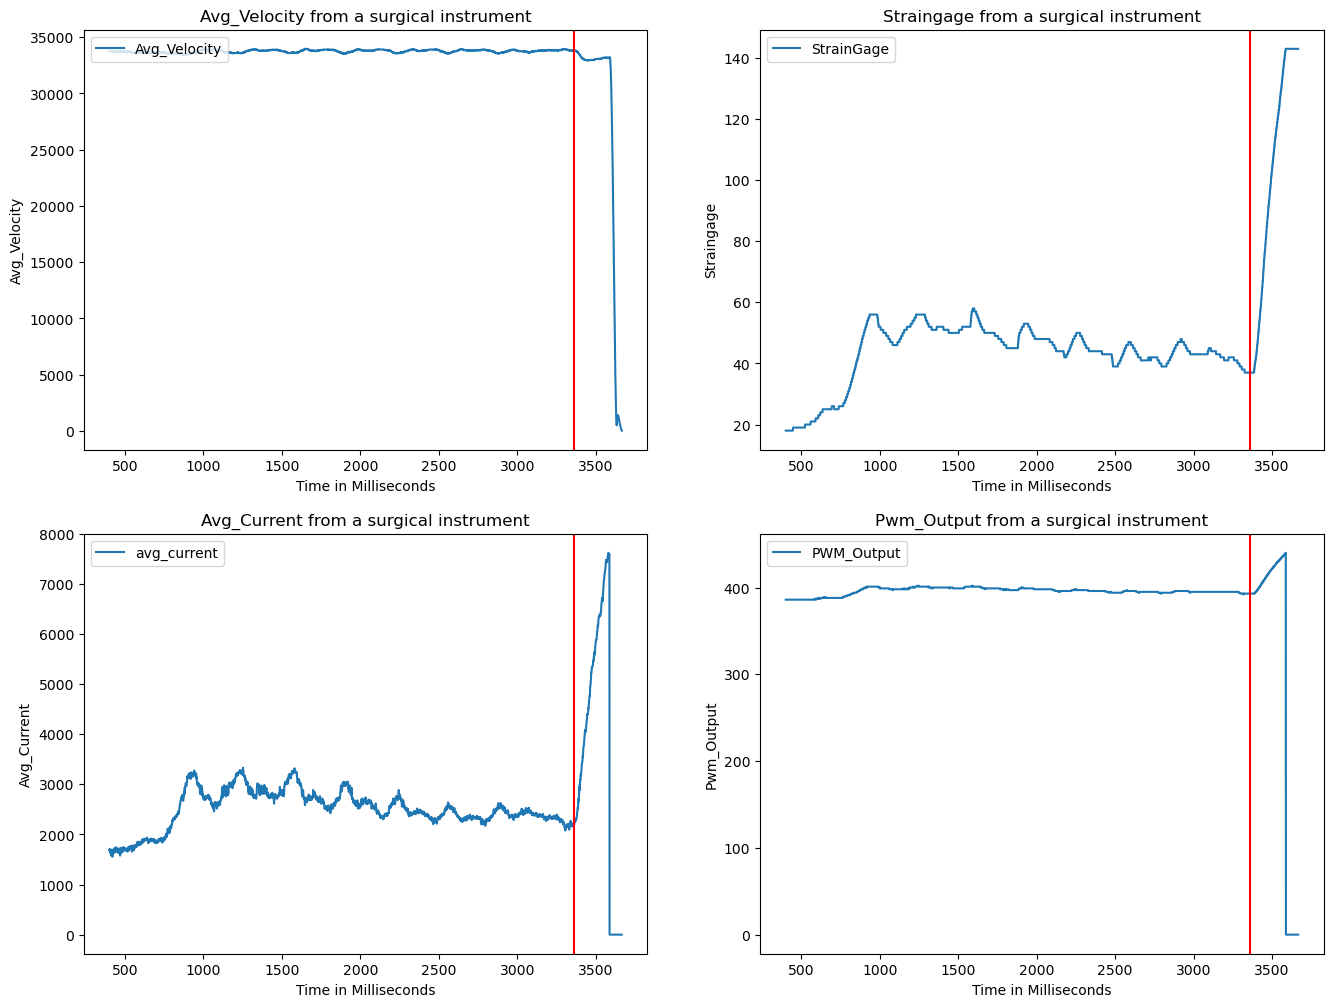

In [9]:
data_100=data["id"]==100
plot_measure(data[data_100])

In [10]:
print(data.info())
print(normal.info())
print(annomally.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183010 entries, 0 to 3183009
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int64  
 1   TimeMS                 int64  
 2   Avg_Velocity           float64
 3   PWM_Output             int64  
 4   SG_NoFilter            int64  
 5   Setpoint               int64  
 6   StrainGage             int64  
 7   avg_current            int64  
 8   current_filter         int64  
 9   ticks                  int64  
 10  Anomaly_At_Time_ms     int64  
 11  Articulation           object 
 12  Tissue                 object 
 13  Tissue_Thickness_inch  float64
 14  Firing_Type            object 
dtypes: float64(2), int64(10), object(3)
memory usage: 364.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006275 entries, 0 to 1006274
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 ----------

In [11]:
annomally.isnull().sum()[annomally.isnull().sum()>0]

Series([], dtype: int64)

In [12]:
normal.isnull().sum()[normal.isnull().sum()>0]

Series([], dtype: int64)

In [13]:
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

In [14]:
r_train=0.7
n_good = int(normal_feature.shape[0] * r_train)
n_bad = int(annomally_feature.shape[0] * r_train)
print("n_good: ",n_good)
print("n_bad: ",n_bad)

n_good:  704392
n_bad:  31628


In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
hmm_states=2
print(normal_feature.index)
print(n_good, normal_feature.shape[0])
normal_feature = normal_feature.reset_index(drop=True)
tmp = [(normal_feature.iloc[i, :]).T for i in range(n_good, normal_feature.shape[0])]
feat_train = np.concatenate(tmp, axis=0)
feat_train = feat_train.reshape(-1, 1)

len_train = [m.shape[0] for m in tmp]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(feat_train)

model = hmmlearn.hmm.GaussianHMM(n_components=hmm_states)
model.fit(scaler.transform(feat_train), lengths=len_train)

RangeIndex(start=0, stop=1006275, step=1)
704392 1006275


GaussianHMM(n_components=2)

In [57]:
tmp1 = np.concatenate([(normal_feature.iloc[i, :]).T for i in range(n_good, normal_feature.shape[0])], axis=0).reshape(-1, 1)

tmp2= np.concatenate([(annomally_feature.iloc[i, :]).T for i in range(n_bad, annomally_feature.shape[0])], axis=0).reshape(-1, 1)


In [74]:
lr=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(),sklearn.linear_model.LogisticRegression(),)

lr.fit(np.concatenate([tmp1,tmp2],axis=0),np.array([0]*len(tmp1) + [1]*len(tmp2)))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [93]:
input_array = np.concatenate([(normal_feature.iloc[i, :]).T for i in range(normal_feature.shape[0])], axis=0).reshape(-1, 1)
tmp1_test=[model.score(scaler.transform(input_array))]
input_array2 = np.concatenate([(annomally_feature.iloc[i, :]).T for i in range(annomally_feature.shape[0])], axis=0).reshape(-1, 1)
tmp2_test=[model.score(scaler.transform(input_array2))]
    

In [94]:
print(tmp1_test)
print(tmp2_test)

[-3190090.4356378904]
[-165240.44994859703]


In [95]:
result=lr.predict(np.concatenate([np.reshape(tmp1_test,(-1,1)),np.reshape(tmp2_test,(-1,1))],axis=0))
print("Result: ",result)

Result:  [1 0]


In [96]:
actual = np.array([(0)*len(tmp1), (1)*len(tmp2)])

In [97]:
actual

array([    0, 54220])